---

##  Portfolio Optimization

1. Will take all data from the portfolio management 
2. perform the rebalancing based on the variable to maximize, minimize or to target

Thus:
- A method to call all chosen stratgies return and cumulative return + combine them into one df
- A method for the objective function to optimize
- A method to implement walk forward analysis and outputs the returns and cumulative of the strategy
 
Note that when comparing returns for rebalancing, don't account for previous weights, only consider absolute percentage performance.

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process


---

Idea: Get strategy returns from portfolio management -> Perform Walk Forward Optimization for the weights of the strategy returns -> Get the cumulative return of the overall portfolio

In [2]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low


Skipping category 'layer-1', already processed.
Skipping category 'depin', already processed.
Skipping category 'proof-of-work-pow', already processed.
Skipping category 'proof-of-stake-pos', already processed.
Skipping category 'meme-token', already processed.
Skipping category 'dog-themed-coins', already processed.
Skipping category 'eth-2-0-staking', already processed.
Skipping category 'non-fungible-tokens-nft', already processed.
Skipping category 'governance', already processed.
Skipping category 'artificial-intelligence', already processed.
Skipping category 'infrastructure', already processed.
Skipping category 'layer-2', already processed.
Skipping category 'zero-knowledge-zk', already processed.
Skipping category 'storage', already processed.
Skipping category 'oracle', already processed.
Skipping category 'bitcoin-fork', already processed.
Skipping category 'restaking', already processed.
Skipping category 'rollup', already processed.
Skipping category 'metaverse', already p

In [3]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [4]:
start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2020, 3, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns        high  log_return  \
date                coin                                                    
2020-01-01 01:00:00 ADAUSDT     0.03299  1.006406     0.03303    0.006386   
                    BNBUSDT    13.79950  1.007402    13.80000    0.007375   
                    BTCUSDT  7216.27000  1.005469  7230.00000    0.005454   
                    ETHUSDT   130.64000  1.013735   130.65000    0.013641   
                    XRPUSDT     0.19371  1.006390     0.19372    0.006370   
...                                 ...       ...         ...         ...   
2020-02-29 23:00:00 ADAUSDT     0.04710  1.436852     0.04801   -0.017051   
                    BNBUSDT    19.23000  1.403844    19.71550   -0.022028   
                    BTCUSDT  8523.61000  1.187625  8659.96000   -0.012943   
                    ETHUSDT   217.21000  1.685497   223.75000   -0.027920   
                    XRPUSDT     0.22892  1.189318     0.23472   -0.022119   

                                    low        open       price   returns  \
date                coin                                                    
2020-01-01 01:00:00 ADAUSDT     0.03276     0.03277     0.03299  0.006406   
                    BNBUSDT    13.69530    13.69810    13.79950  0.007402   
                    BTCUSDT  7175.71000  7176.47000  7216.27000  0.005469   
                    ETHUSDT   128.78000   128.87000   130.64000  0.013735   
                    XRPUSDT     0.19237     0.19243     0.19371  0.006390   
...                                 ...         ...         ...       ...   
2020-02-29 23:00:00 ADAUSDT     0.04707     0.04793     0.04710 -0.016907   
                    BNBUSDT    19.22960    19.66980    19.23000 -0.021787   
                    BTCUSDT  8523.55000  8634.94000  8523.61000 -0.012860   
                    ETHUSDT   217.00000   223.35000   217.21000 -0.027534   
                    XRPUSDT     0.22870     0.23404     0.22892 -0.021877   

                                   volume  volume_in_dollars  
date                coin                                      
2020-01-01 01:00:00 ADAUSDT  1.560752e+06       5.148920e+04  
                    BNBUSDT  5.379125e+04       7.422924e+05  
                    BTCUSDT  8.830526e+02       6.372346e+06  
                    ETHUSDT  1.134466e+04       1.482066e+06  
                    XRPUSDT  2.339976e+06       4.532768e+05  
...                                   ...                ...  
2020-02-29 23:00:00 ADAUSDT  8.772487e+06       4.131841e+05  
                    BNBUSDT  1.666720e+05       3.205104e+06  
                    BTCUSDT  2.007037e+03       1.710720e+07  
                    ETHUSDT  3.525650e+04       7.658064e+06  
                    XRPUSDT  6.806156e+06       1.558065e+06  

[7165 rows x 10 columns]

---

Call each Strategy

In [5]:
mr_strat_1 = Last_Days_Low(data, objective = 'multiple')
tf_strat_1 = Sprtrnd_Breakout(data, objective = 'multiple')

In [6]:
mr_strat_1.test()

0.9985940661180278
1.0001144711726988
1.288622946680158
1.3073460722392323
1.4287666017137808
1.0612887315816182
0
0
0
1.0684292610821409
{'std_window': 19, 'mean_window': 6, 'ema_window': 85, 'hourly_lookback': 3, 'daily_lookback': 3, '_min_pos': 0.6949941493453458, '_max_pos': 0.727271995856421, 'sl_ind_length': 20, 'sl_ind_mult': 3.066997884824298, 'tp_mult': 5, 'ptp_mult': 1.9611720243493493, 'ptp_exit_percent': 0.8600804638103364}
[19, 6, 85, 3, 3, 0.6949941493453458, 0.727271995856421, 20, 3.066997884824298, 5, 1.9611720243493493, 0.8600804638103364]
Out-of-sample performance: 1.0589178981156397
1.0124721972172892
0.999665509649909
0.9997335036910644
1.1341809296567864
1.0589178981156397
1.0806407355859902
1.2811938210727913
1.0643701821242288
1.0370345267507624
0.9968798310383705
{'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'hourly_lookback': 4, 'daily_lookback': 3, '_min_pos': 0.6947256588850119, '_max_pos': 0.6510770255019446, 'sl_ind_length': 46, 'sl_ind_mult': 4.32

In [7]:
tf_strat_1.test()

1.1401842662328976
1.0007049024869508
1.5193259621884048
1.6804967185960136
1.5702707563012241
1.1449014085051252
1.5355982200464602
1.870886167927002
1.3102038770459095
1.12710874841073
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.28719515606534246, '_max_pos': 0.971712095389104, 'sl_ind_length': 43, 'sl_ind_mult': 3.7477828452419297, 'tp_mult': 3, 'ptp_mult': 1.256068322761324, 'ptp_exit_percent': 0.1363902305845882}
[22, 22, 61, 17, 3, 0.28719515606534246, 0.971712095389104, 43, 3.7477828452419297, 3, 1.256068322761324, 0.1363902305845882]
Out-of-sample performance: 1.564044826286511
1.0186769910984994
1.000098214684256
1.530392934140407
0.9796110485991647
1.382606026212551
1.1024823208280017
1.3986461447622471
1.564044826286511
1.1992069124942581
1.0486127064211068
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.28719515606534246, '_max_pos': 0.971712095389104, 'sl_ind_l

---

<Axes: xlabel='date,coin'>

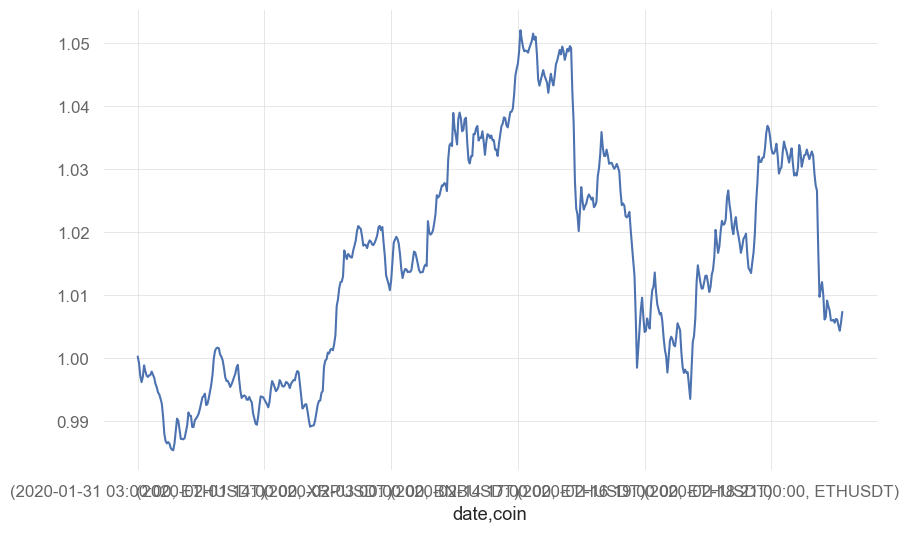

In [58]:
mr_strat_1.results.cstrategy.plot()

<Axes: xlabel='date,None'>

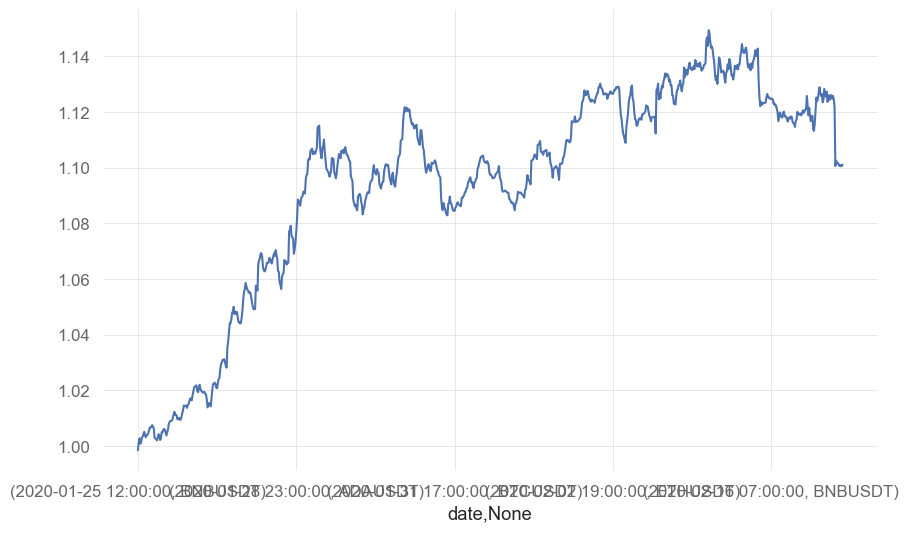

In [59]:
tf_strat_1.results.cstrategy.plot()

In [9]:
#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)
cash_df
strategy_map = {'cash_strat': cash_df.strategy,
                'mr_strat_1': mr_strat_1.results.strategy,
                'tf_strat_1': tf_strat_1.results.strategy}

In [22]:
weights = [0.34, 0.34, 0.33]
log_rets = pd.concat(strategy_map, axis = 1).fillna(0)

log_rets

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         0.0         0.0
                    BNBUSDT         0.0         0.0         0.0
                    BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
                    XRPUSDT         0.0         0.0         0.0
...                                 ...         ...         ...
2020-02-29 23:00:00 ADAUSDT         0.0         0.0         0.0
                    BNBUSDT         0.0         0.0         0.0
                    BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
                    XRPUSDT         0.0         0.0         0.0

[7165 rows x 3 columns]

<Axes: >

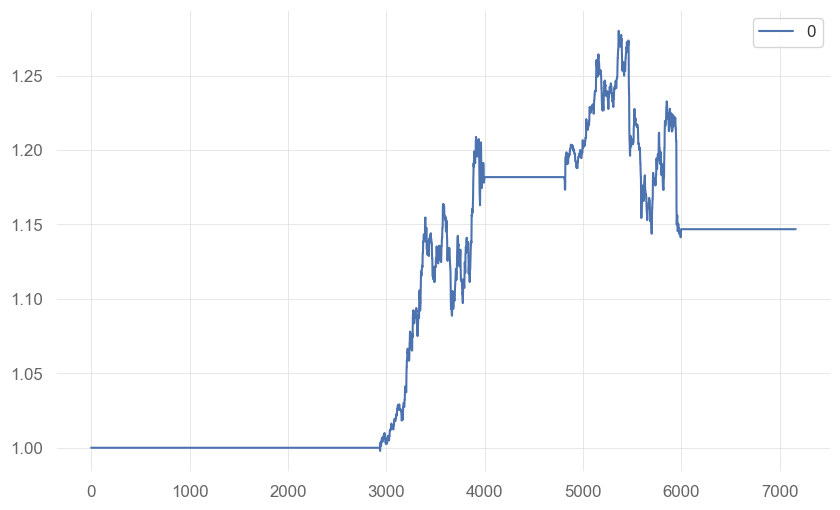

In [30]:
def calculate_returns(weights, log_rets):
    return np.dot(weights, log_rets.T)

pd.DataFrame(calculate_returns(weights, log_rets)).cumsum().apply(np.exp).plot()

In [51]:
equal_weights = np.array([1 / len(log_rets.columns)] * len(log_rets.columns))
bounds = [(0, 1)] * len(log_rets.columns)

equal_weights, bounds

(array([0.33333333, 0.33333333, 0.33333333]), [(0, 1), (0, 1), (0, 1)])

In [56]:
def function_to_minimize(weights, log_rets):
    #Minimize a -1 * Sharpe Ratio
    return -1 * np.sum(log_rets.mean()*weights) * 252

In [60]:
from scipy.optimize import minimize
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
starting_guess = equal_weights

# Call the minimize function

result = minimize(
fun= lambda weights: function_to_minimize(weights, log_rets),  # Minimize negative performance
x0=starting_guess,  # Starting point for optimization
bounds=bounds,  # Bounds for each weight
constraints=sum_constraint  # Constraint: weights sum to 1
)

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.013549131437735125
       x: [ 4.607e-16  1.089e-15  1.000e+00]
     nit: 7
     jac: [ 0.000e+00 -1.022e-03 -1.355e-02]
    nfev: 28
    njev: 7

In [139]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import quantstats_lumi as qs

class WFO():
    def __init__(self, strategies, 
                 train_size = 1000, 
                 test_size = 1000, 
                 step_size = 1000, 
                 objective = 'sharpe',
                 opt_freq = 'custom'):
        """
        This class performs a walk-forward optimization on a trading strategy.

        Parameters:
        data (pd.DataFrame): The historical data to be used for backtesting.
        trading_strategy (object): The trading strategy to be optimized.
        param_grid (dict): The grid of parameters to be optimized.
        train_size (int): The number of data points to be used for training.
        test_size (int): The number of data points to be used for testing.
        step_size (int): The number of data points to step forward in each iteration.
        optimize_fn (str): The optimization function to use ("grid" or "gp").
        objective (str): The objective function to maximize ("sharpe", "sortino", "calmar", "multiple").
        opt_period (str): The period to optimize over ['custom', 'daily', 'weekly', 'quarterly', 'semi-annually', 'yearly'].
        """
        self.strategies = strategies
        if opt_freq == 'custom':
            self.train_size = train_size
        else:
            self.train_size = train_size = self.opt_freq(opt_freq)
        self.test_size = test_size
        self.step_size = step_size
        self.objective = objective
        
        
        if step_size + train_size + test_size > len(data):
            raise ValueError("Invalid train, test, or step size.")
        elif train_size < 1 or test_size < 1 or step_size < 1:
            raise ValueError("Train, test, and step size must be greater than 0.")
        elif test_size < train_size:
            raise ValueError("Test size must be greater or equal to train size.")
        
                            
    #### Helper Methods ####
    def split_data(self, data, train_size, test_size, step_size):
        start = 0
        while start + train_size + test_size <= len(data):
            train = data.iloc[start:start + train_size]
            test = data.iloc[start + train_size:start + train_size + test_size]
            yield train, test
            start += step_size
            
    def calculate_returns(self, weights, log_rets):
        return np.dot(weights, log_rets.T)
    
    def bounds(self, N):
        # Initialize an empty list to collect the inner tuples
        collected_tuples = []
            
        # Iterate n times to create n inner tuples
        for _ in range(N):
            # Append the specific numbers as a tuple to the list
            collected_tuples.append((0, 1))
            
            # Convert the list of tuples to a tuple of tuples and return it
        return tuple(collected_tuples)
            

    def objective_function(self, weights, train_data):
        """
        Calculate the objective function for the optimization.

        Note that we have only included objective functions that we want to maximize.
        """

        strategy_combined = pd.DataFrame(self.calculate_returns(weights, train_data))[0]

        if strategy_combined.sum() == 0:
            return 0

        try:
            if self.objective == "multiple":
                creturns = strategy_combined.cumsum().apply(np.exp)
                performance = creturns.iloc[-1]
            elif self.objective == "sharpe":
                performance = qs.stats.sharpe(strategy_combined)
            elif self.objective == "sortino":
                performance = qs.stats.sortino(strategy_combined)
            elif self.objective == "calmar": 
                performance = qs.stats.calmar(strategy_combined)
            else:
                raise ValueError("Invalid objective function")
        except Exception as e:
            print(f"Error calculating performance: {e}")
            performance = 0

        return performance
    
    def opt_freq(self, opt_freq):
        time_diff = self.data.unstack().index.get_level_values(0)[1] - self.data.unstack().index.get_level_values(0)[0]

        if opt_freq == 'daily':
            return pd.Timedelta('1 day') // time_diff
        elif opt_freq == 'weekly':
            return pd.Timedelta('1 w') // time_diff
        elif opt_freq == 'monthly':
            return pd.Timedelta('1 m') // time_diff
        elif opt_freq == 'quarterly':
            return pd.Timedelta('3 m') // time_diff
        elif opt_freq == 'semi-annually':
            return pd.Timedelta('6 m') // time_diff
        elif opt_freq == 'yearly':
            return pd.Timedelta('1 y') // time_diff
        else:
            raise ValueError("Invalid optimization frequency")
        


    #### Optimization Methods ####
    
    def optimize_weights_minimize(self, train_data):
        """
        Optimize the weights of a trading strategy using Bayesian optimization.
        """
        equal_weights = np.array([1 / len(self.strategies.columns)] * len(self.strategies.columns))
        bounds = self.bounds(len(self.strategies.columns))
        
        sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        starting_guess = equal_weights
        
        # Call the minimize function
        result = minimize(
        fun=lambda weights: -self.objective_function(weights, train_data),  # Minimize negative performance
        x0=starting_guess,  # Starting point for optimization
        bounds=bounds,  # Bounds for each weight
        constraints=sum_constraint  # Constraint: weights sum to 1
        )
        
        return result.x

   
    def test_weights(self, weights, test_data):
        
        result = self.calculate_returns(weights, test_data)
        peformance = self.objective_function(weights, test_data)
        return peformance, result


    def walk_forward_optimization(self):
        """
        Perform a walk-forward optimization on a dataset.
        """
        all_performance = []
        all_results = []
        for train, test in self.split_data(self.strategies, self.train_size, self.test_size, self.step_size):
            # Optimize on training data    
            weights = self.optimize_weights_minimize(train)
            
            # Test on out-of-sample data
            performance, result = self.test_weights(test, weights)
            print(f"Out-of-sample performance: {performance}")
            
            all_performance.append(performance)
            all_results.append(pd.DataFrame(result))
        
        all_results = pd.concat(all_results).reset_index(drop = True)
        return all_performance, all_results


In [140]:
wfo = WFO(strategies = log_rets, train_size = 1000, test_size = 1000, step_size = 1000, objective = 'multiple')

In [141]:
all_performance, all_results = wfo.walk_forward_optimization()

Out-of-sample performance: 0
Out-of-sample performance: 1.0026573977322712
Out-of-sample performance: 1.5516419359017726
Out-of-sample performance: 1.0647326063147773
Out-of-sample performance: 0.8827062737667963
Out-of-sample performance: 0


In [142]:
all_results

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5995,0.0
5996,0.0
5997,0.0
5998,0.0


In [145]:
creturns = all_results.cumsum().apply(np.exp)

<Axes: >

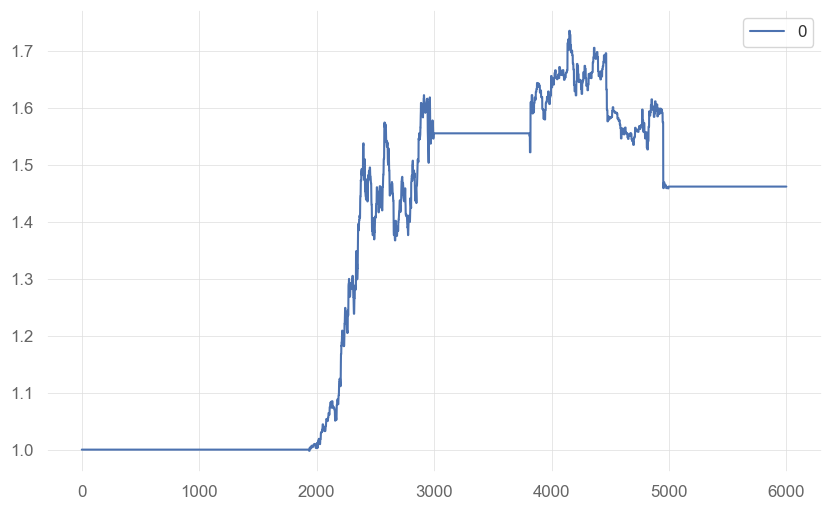

In [147]:
creturns.plot()